In [264]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from random import randint

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [265]:
COLOR_MAP = {
    "red": "#f44336",
    "pink": "#FFC0CB",
    "purple": "#9c27b0",
    "blue": "#2196f3",
    "green": "#4caf50",
    "yellow": "#ffeb3b",
    "orange": "#ff9800",
    "brown": "#795548",
    "black": "#333333",
    "grey": "#777777",
    "white": "#eeeeee",
}

PLOT_COLORS = [
    "white",
    COLOR_MAP["red"],
    COLOR_MAP["blue"],
    COLOR_MAP["green"],
    COLOR_MAP["yellow"],
    COLOR_MAP["orange"],
    COLOR_MAP["purple"],
    COLOR_MAP["pink"],
    COLOR_MAP["brown"],
    COLOR_MAP["black"],
    COLOR_MAP["grey"],
    COLOR_MAP["white"],
]


In [266]:
class InvalidMove(Exception):
    pass


class GameLogic:
    boards = []
    owners = {}
    addresses = []

    def __init__(self, addresses: list) -> None:
        self.addresses = addresses

    def reset(self):
        self.boards = []
        self.owners = {}

    def after_move(self):
        pass

    def score(self):
        board = self.game_board()
        unique, counts = np.unique(board, return_counts=True)

        scores = {}

        for u, c in zip(unique, counts):
            if u == 0:
                continue

            scores[self.addresses[int(u) - 1]] = c

        return scores

    def render(self):
        data = self.game_board()

        cmap = colors.ListedColormap(PLOT_COLORS)
        bounds = np.linspace(0, len(PLOT_COLORS), len(PLOT_COLORS) + 1)
        norm = colors.BoundaryNorm(bounds, cmap.N)

        fig, ax = plt.subplots()
        ax.imshow(data, cmap=cmap, norm=norm)
        ax.grid(False)

        plt.show()

    def game_board(self):
        if len(self.boards) > 64:
            raise Exception("Not implemented - too many boards")

        rows = (len(self.boards) - 1) // 4 + 1
        cols = len(self.boards)
        if cols > 4:
            cols = 4

        board = np.zeros(((rows * 8), (cols * 8)))

        for i in range(16):
            row = i // 4  # calculate the row index in the grid
            col = i % 4  # calculate the column index in the grid

            # calculate the indices for the current array in the combined array
            row_start = row * 8
            row_end = (row + 1) * 8
            col_start = col * 8
            col_end = (col + 1) * 8

            if i >= len(self.boards):
                break

            board[row_start:row_end, col_start:col_end] = self.boards[i]

        return board

    def expand(self, address: str):
        board_id = len(self.boards)
        board = np.full((8, 8), 0)

        self.boards.append(board)
        self.owners[board_id] = address

        return self.boards

    def get_tile(self, board_id, y, x):
        if y < 0 or y > 7:
            return None

        if board_id >= len(self.boards):
            raise Exception("Board not found")

        if x > 7:
            board_id += 1
            x = 0

        elif x < 0:
            board_id -= 1
            x = 7

        if board_id < 0 or board_id >= len(self.boards):
            return None

        account = self.boards[board_id][y][x]

        if account == 0:
            return None

        return {
            "account": account,
            "owner": self.owners[board_id],
            "board": board_id,
            "y": y,
            "x": x,
        }

    def capture(self, tile):
        board_id = tile["board"]
        y = tile["y"]
        x = tile["x"]

        left = self.get_tile(board_id, y, x - 1)
        right = self.get_tile(board_id, y, x + 1)
        above = self.get_tile(board_id, y - 1, x)
        below = self.get_tile(board_id, y + 1, x)

        if left and right and above and below:
            self.boards[board_id][y][x] = 0

    def place(self, address: str, moves: list):
        address_map = {a: i + 1 for i, a in enumerate(self.addresses)}
        account_id = address_map[address]

        for board_id, y, x in moves:
            tile = self.get_tile(board_id, y, x)

            # open tiles only
            if tile is not None:
                raise InvalidMove("Tile is occupied")

            is_owner = self.owners[board_id] == address
            is_edge = x == 0 or x == 7 or y == 0 or y == 7

            left = self.get_tile(board_id, y, x - 1)
            right = self.get_tile(board_id, y, x + 1)
            above = self.get_tile(board_id, y - 1, x)
            below = self.get_tile(board_id, y + 1, x)

            # make the move
            def _move():
                self.boards[board_id][y][x] = account_id

            # the owner can always place on their edges
            if is_owner and is_edge:
                _move()

            elif left and left["account"] == account_id:
                _move()

            elif right and right["account"] == account_id:
                _move()

            elif above and above["account"] == account_id:
                _move()

            elif below and below["account"] == account_id:
                _move()

            else:
                raise InvalidMove("Invalid move")

            tile = self.get_tile(board_id, y, x)
            [self.capture(t) for t in [tile, left, right, above, below] if t]

        self.after_move()

        return self.boards[board_id]


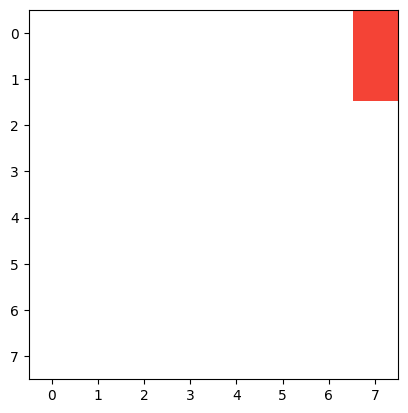

In [267]:
game = GameLogic(["alice", "bob", "john"])
game.reset()
game.expand("alice")
game.place("alice", [[0, 0, 7], [0, 1, 7]])
game.render()


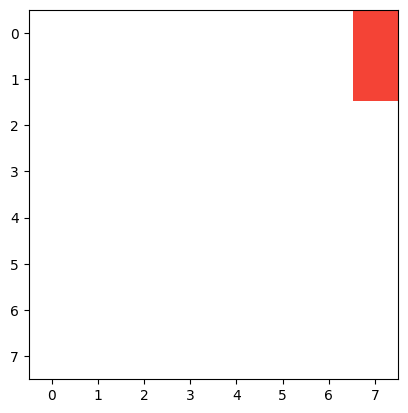

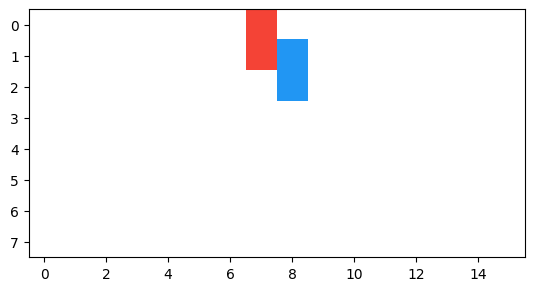

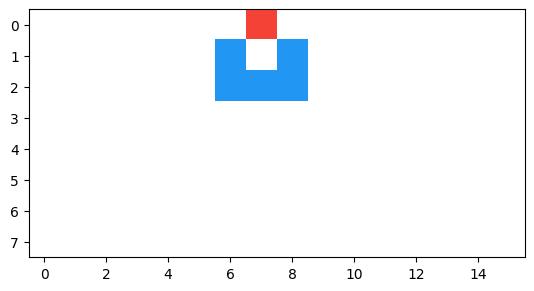

{'alice': 1, 'bob': 5}

In [268]:
# Shows capture function
game.reset()

game.expand("alice")
game.place("alice", [[0, 0, 7], [0, 1, 7]])
game.render()

game.expand("bob")
game.place("bob", [[1, 1, 0], [1, 2, 0]])
game.render()

game.place("bob", [[0, 2, 7], [0, 2, 6], [0, 1, 6]])
game.render()
game.score()


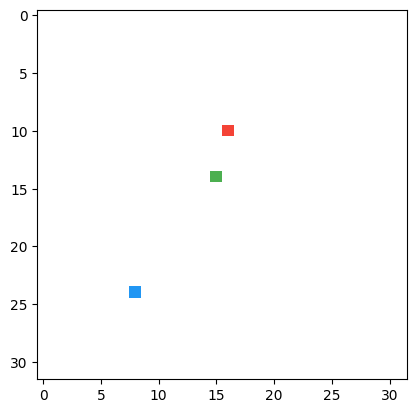

{'alice': 1, 'bob': 1, 'john': 1}


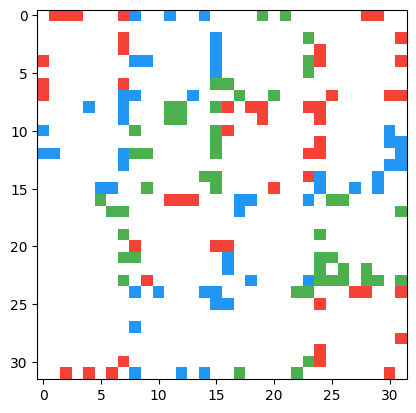

{'alice': 51, 'bob': 51, 'john': 51}


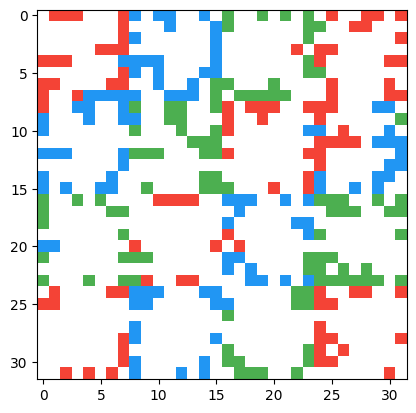

{'alice': 98, 'bob': 101, 'john': 100}


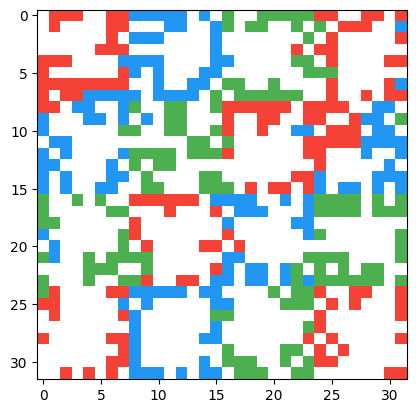

{'alice': 142, 'bob': 142, 'john': 141}


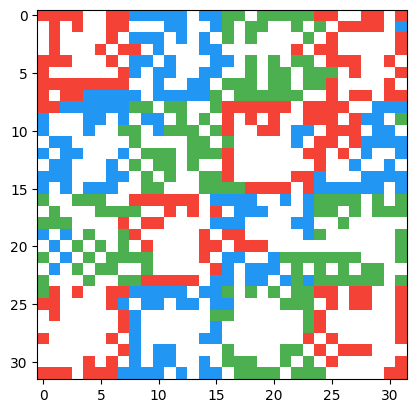

{'alice': 177, 'bob': 174, 'john': 173}


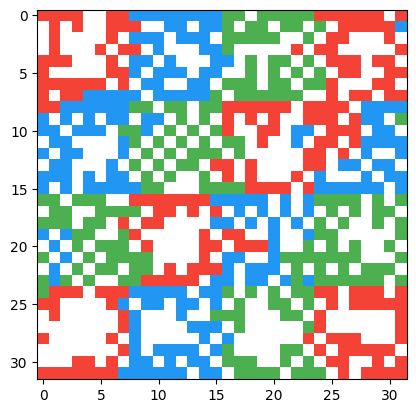

{'alice': 210, 'bob': 200, 'john': 195}


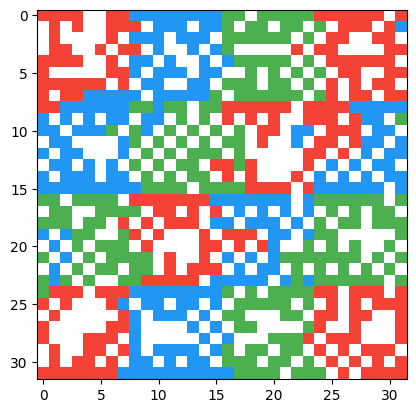

{'alice': 227, 'bob': 215, 'john': 216}


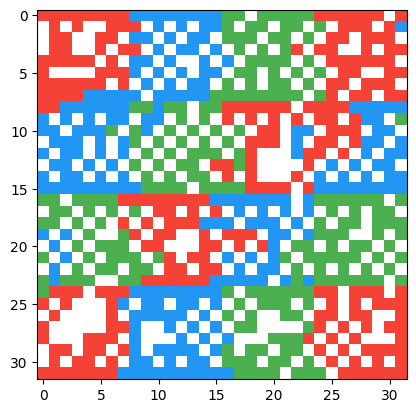

{'alice': 249, 'bob': 221, 'john': 217}


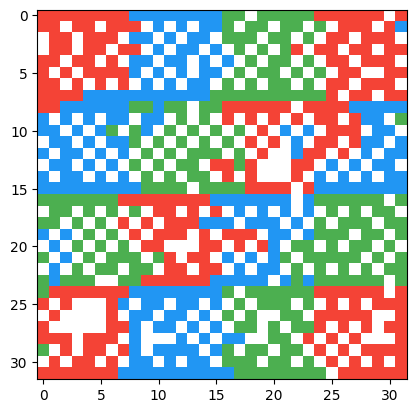

{'alice': 256, 'bob': 223, 'john': 222}


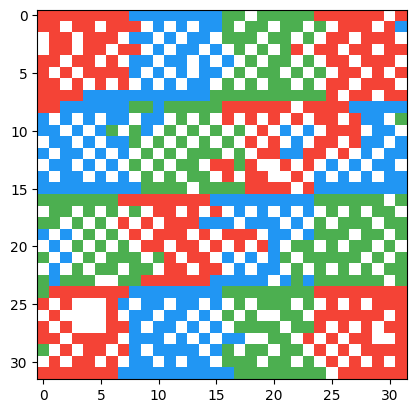

{'alice': 263, 'bob': 227, 'john': 225}


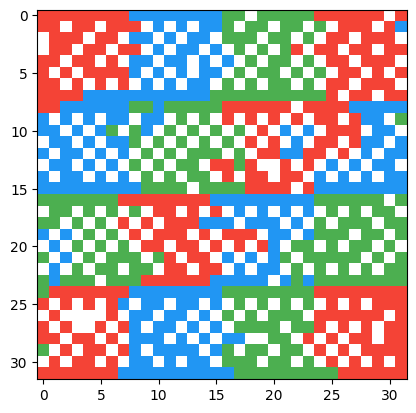

{'alice': 265, 'bob': 227, 'john': 228}


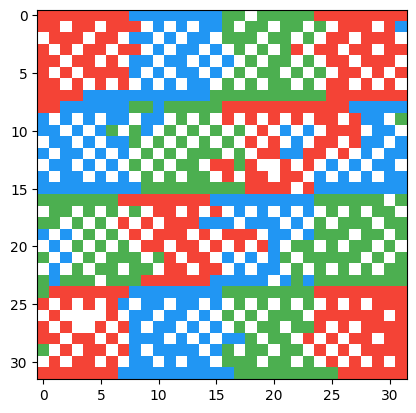

{'alice': 269, 'bob': 227, 'john': 229}


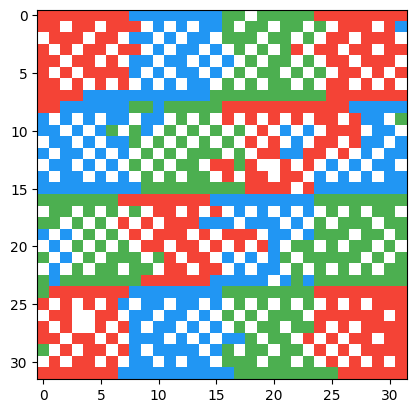

{'alice': 271, 'bob': 227, 'john': 231}


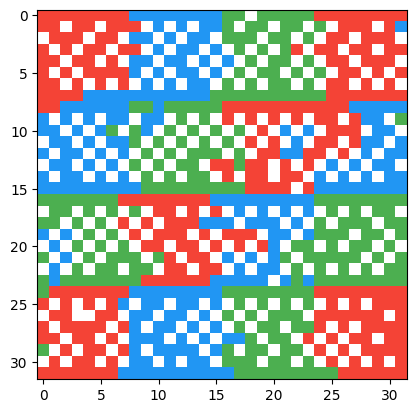

{'alice': 274, 'bob': 227, 'john': 231}


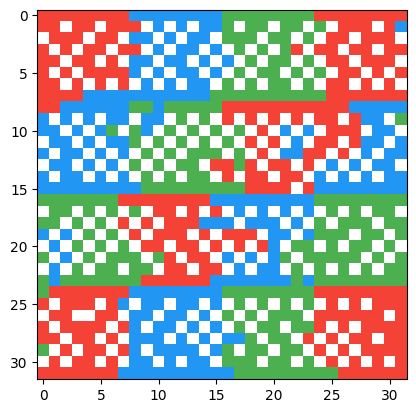

{'alice': 274, 'bob': 228, 'john': 232}


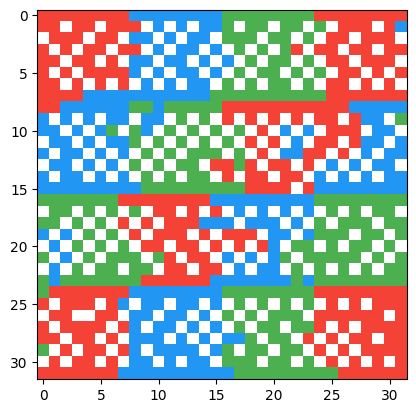

{'alice': 274, 'bob': 228, 'john': 232}


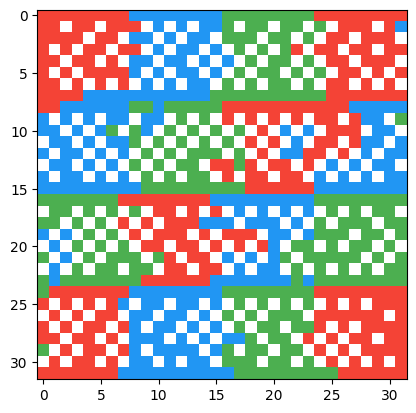

{'alice': 274, 'bob': 228, 'john': 232}


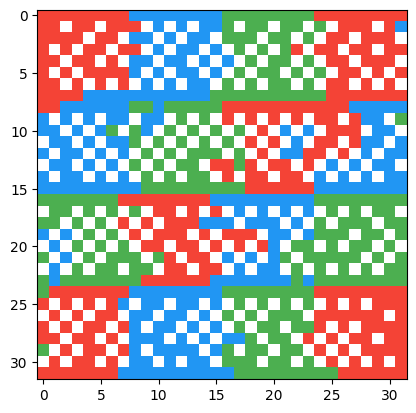

{'alice': 274, 'bob': 228, 'john': 232}


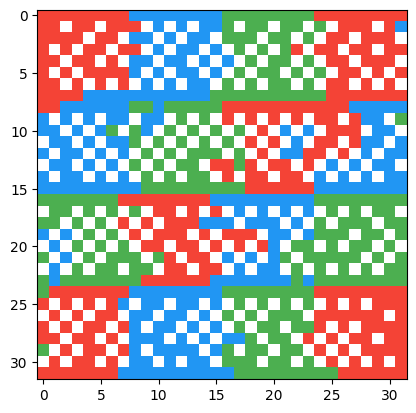

{'alice': 274, 'bob': 228, 'john': 232}


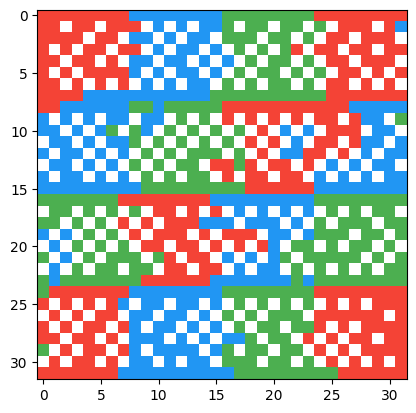

{'alice': 274, 'bob': 228, 'john': 232}


In [269]:
# Shows capture function
game.reset()

players = ["alice", "bob", "john"]
board_count = 16

for i in range(board_count):
    game.expand(players[i % 3])

for i in range(1000):
    for player in players:
        # try placing 100 times
        for _ in range(100):
            move = [randint(0, board_count - 1), randint(0, 7), randint(0, 7)]
            try:
                game.place(player, [move])
                break
            except InvalidMove:
                pass

    if i % 50 == 0:
        game.render()
        print(game.score())
